<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_11_29).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第9回）**##
（執筆中）

状態空間モデルとは、時系列データ（観測値）の生成を、その時系列の背後にある状態の時間変化と、その状態の観測に分けて捉えるモデルである。

$l$成分の時系列$y_n$があり、直接は観察できない状態$x_n$を$k$次元ベクトルとする。以下を状態空間モデルという。
$$x_n = F_nx_{n-1}+G_nv_n \tag{1}$$
$$y_n = H_nx_n + w_n\tag{2}$$
式(1)をシステムモデル、式(2)を観測モデルという。
$v_n$は正規白色雑音で分散共分散行列$Q_n$のシステムノイズ、
$w_n$は正規白色雑音で分散共分散行列$R_n$の観測ノイズであり、いずれも平均は零ベクトル。
$F_n$は$k\times k$行列、$G_n$は$k\times m$行列、$H_n$は$l\times k$行列。

時系列解析に用いられる線形モデルを状態空間モデルに表すことができる。

例えば、前回の自己回帰モデルで、$m$次のARモデルを考える。
$$
y_n = \sum_{i=1}^m a_iy_{n-i} + v_n \tag{3}
$$
状態ベクトル$x_n$を
$$
x_n = \left (
\begin{matrix}
y_n\\
y_{n-1}\\
\vdots\\
y_{n-m+1}
\end{matrix}
\right )\tag{4}
$$
と定義すると、式(1)と(3)より、
$$
F=
\left (
\begin{matrix}
a_1 & a_2 & \cdots & a_m\\
1 && & \\
&  \ddots &&&\\
& &  1 & 0
\end{matrix}
\right )
$$

$$
G=
\left (
\begin{matrix}
1\\
0\\
\vdots\\
0
\end{matrix}
\right )
$$

式(2)と(4)より
$$
H=
\left ( 1, 0, \cdots, 0\right )
$$
また、システムノイズおよび観測ノイズを$Q=\sigma^2$、$R=0$とおけば、ARモデルの状態空間モデルによる表現となる。

##**カルマンフィルタによる状態推定**##
観測値$Y_j=\{y_1,\cdots,y_j\}$が得られたときに、時刻$n$における状態$x_n$の推定問題。


*   $j<n$ 予測
*   $j=n$ フィルタ
*   $j>n$ 平滑化

$Y_j$が得られたときの$x_n$の条件付き平均と分散共分散行列を
$$
x_{n|j} = E[x_n | Y_j]\\
V_{n|j} = E[(x_n-x_{n|j})(x_n-x_{n|j})^T]
$$
と表す。

次の２段階で、時刻$n$の状態$x_n$を推定する。

**予測ステップ**
$$
x_{n|n-1} = F_nx_{n-1|n-1}\\
V_{n|n-1} = F_nV_{n-1|n-1}F_n^T+G_nQ_nG_n^T
$$

**フィルタリングステップ**

$$
K_n=V_{n|n-1}H_n^T\left(H_nV_{n|n-1}H_n^T+R_n \right)^{-1}\\
x_{n|n}=x_{n|n-1}+K_n\left(y_n - H_n x_{n|n-1} \right)\\
V_{n|n} = \left(I - K_nH_n\right)V_{n|n-1}
$$

まず、予測ステップで、１期先の予測値は、現時点で得られている（１期前で得た）$x_{n-1|n-1}$に$F_n$を演算するのみである。分散共分散行列$V_{n|n-1}$の更新には$F_n$による変換の影響と、システムノイズの影響が入る。

次にフィルタリングステップで、まずカルマンゲイン$K_n$が求められる。
カルマンゲインとは、直感的には、観測されるノイズのうち、システムノイズを起源とする割合である。
$x_{n|n}$の更新式で、右辺第２項の意味は、予測値の観測値に対する誤差をカルマンゲイン分だけ混ぜる。あるいは次のように式変形すると観測値との加重平均とも解釈できる。
$$x_{n|n}=K_ny_n+\left(I - K_nH_n \right)x_{n|n-1}$$
$V_{n|n}$の更新は、$y_n$が入ることによる状態推定の精度改善を表している。


**長期予測**

カルマンフィルタを用いて、長期予測をどのように行えば良いか。
まず、観測値がまだ得られていない１期先について、$Y_{n+1}=Y_{n}$と考える。
そうすると、
$$
E[x_{n+1} | Y_{n+1}] = E[x_{n+1} | Y_n]
$$
より、$x_{n+1|n+1}=x_{n+1|n}$となり、また、
$$
E[(x_{n+1}-x_{n+1|n+1})(x_{n+1}-x_{n+1|n+1})^T]=E[(x_{n+1}-x_{n+1|n})(x_{n}-x_{n+1|n})^T]
$$
より、$V_{n+1|n+1}=V_{n+1|n}$となる。つまり、フィルタリングステップをスキップして、予測ステップだけ回せば良いことが分かる。

$i=1,\cdots,j$について
$$
x_{n+i|n} = F_{n+i}x_{n+i-1|n}\\
V_{n+i|n}=F_{n+i}V_{n+i-1|n}F^T_{n+i}+G_{n+i}Q_{n+i}G^T_{n+i}
$$
$V_{n+i|n}$の式の右辺第２項に必ずシステムノイズの影響が加わるので、予測ステップを繰り返すごとに、予測値分布の分散は大きくなり続ける。

###**解説**###
（カルマンゲイン）

###**平滑化**###
時系列$Y_N=\{y_1,\cdots,y_N\}$が得られたとき、途中の状態$x_n$を推定する。
時間的に逆方向に次のアルゴリズムを適用する。
$$
A_n = V_{n|n}F_{n+1}^TV_{n+1|n}^{-1}\\
x_{n|N} = x_{n|n} + A_n\left(x_{n+1|N}-x_{n+1|n}\right)\\
V_{n|N}=V_{n|n}+A_n\left(V_{n+1|N}-V_{n+1|n} \right)A_n^T
$$
上式に登場する時刻$n=N$の時点での$x_{N|N}$と$V_{N|N}$は平滑化の初期値として必要となるが、カルマンフィルタによって求めておく。

###**プログラム**###


In [1]:
##1変量時系列、AR(1)##
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

time_end = 100
dt = 0.5
time = np.arange(0, time_end, dt)
n_samples = len(time)

# 状態空間モデル #
F=1
H=1
G=1

## Q, Rを変更して、カルマンゲインの値がどのように変わるか確認しよう ##
Q=1 #システムノイズの分散
R=10 #観測ノイズの分散
##

##実験用の時系列生成##
z = np.zeros(n_samples)
y = np.zeros(n_samples)

for i in range(1,n_samples):
#Ground Truth of system state
  z[i] = F*z[i-1]  + G*np.random.normal(0,np.sqrt(Q))
#Observed value
  y[i] = H*z[i]+ np.random.normal(0,np.sqrt(R))


##カルマンフィルタ
xnn_ = np.zeros(n_samples)
xnn = np.zeros(n_samples)

##初期値
Vnn = np.zeros(n_samples)
Vnn[0] = Q

Vnn_=np.zeros(n_samples)
Kn = np.zeros(n_samples)

for i in range(1,n_samples):
  #One-step-ahead forecast step
  xnn_[i] = F*xnn[i-1]
  FT = F
  GT = G
  HT = H
  Vnn_[i] = F*Vnn[i-1]*FT + G*Q*GT

  #Filtering step
  Total_Var_INV = 1/(Vnn_[i]+R)
  Kn[i] = Vnn_[i]*HT*Total_Var_INV

  xnn[i] = xnn_[i] + Kn[i]*(y[i]-H*xnn_[i])
  Vnn[i] = (1-Kn[i]*H)*Vnn_[i]

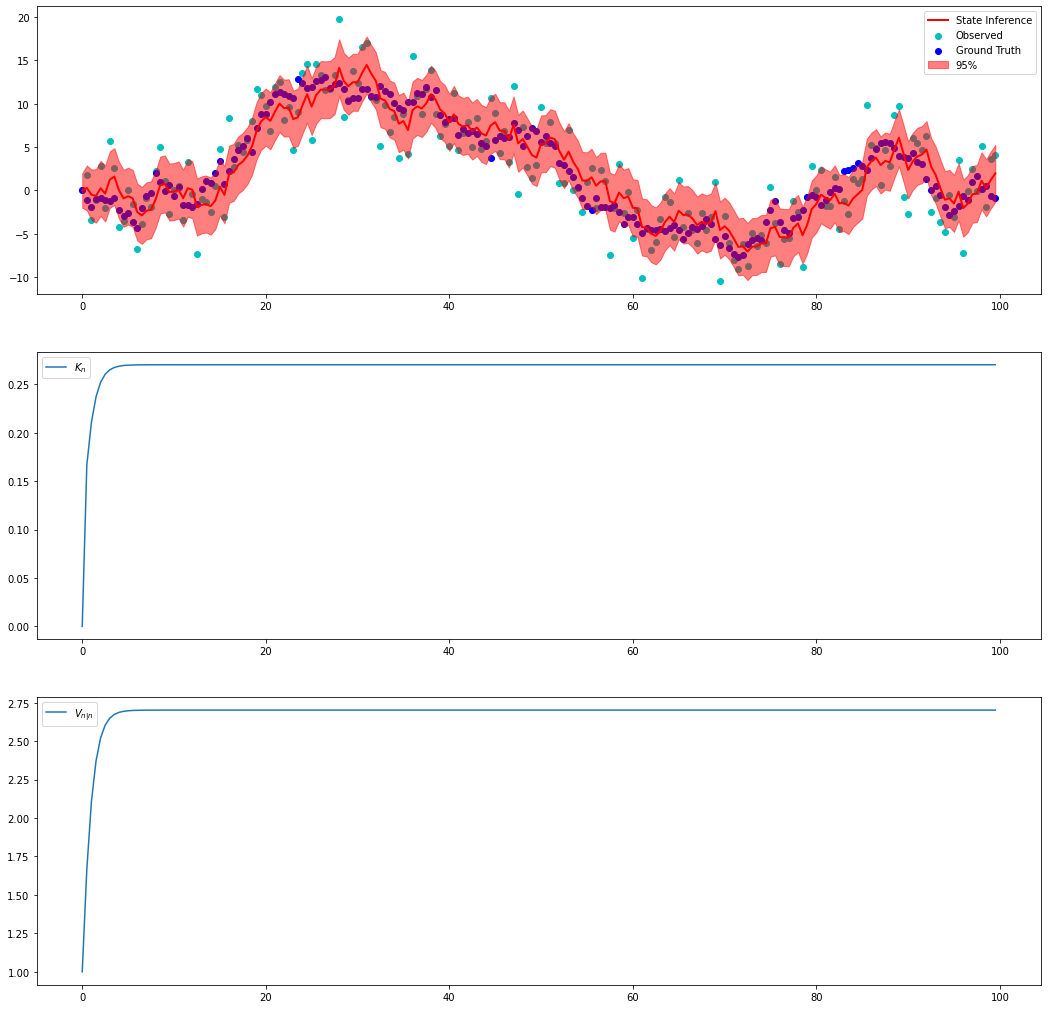

In [2]:
##結果可視化
plt.rcParams["figure.figsize"] = (18, 18)
lower = xnn-2*np.sqrt(Vnn) 
upper = xnn+2*np.sqrt(Vnn) 

plt.subplot(3,1,1)
plt.scatter(time,y,label="Observed",color="c")
plt.scatter(time,z,label="Ground Truth",color="b")
plt.plot(time,xnn,color='r',linewidth=2,label="State Inference")
plt.fill_between(time, lower, upper, color="r", alpha=0.5, label="95%")
plt.legend()
plt.subplot(3,1,2)
plt.plot(time,Kn, label="$K_n$")
plt.legend()
plt.subplot(3,1,3)
plt.plot(time,Vnn, label="$V_{n|n}$")
plt.legend()

In [3]:
##平滑化
An = np.zeros(n_samples)
sx= np.zeros(n_samples)

#初期値
FT = F
GT = G
HT = H
sx[n_samples-1] = xnn[n_samples-1]
VnN = np.zeros(n_samples)
VnN[n_samples-1]= Vnn[n_samples-1]

#Smoothing
for i in range(1,n_samples):
  n=(n_samples-1)-i
  An[n]=Vnn[n]*FT/Vnn_[n+1]
  sx[n]=xnn[n]+An[n]*(sx[n+1]-xnn_[n+1])
  AnT=An[n]
  VnN[n] = Vnn[n]+An[n]*(VnN[n+1]-Vnn_[n+1])*AnT

カルマンフィルタによる推定値は、真値(ground truth)に近い値を推定できていることが分かる。

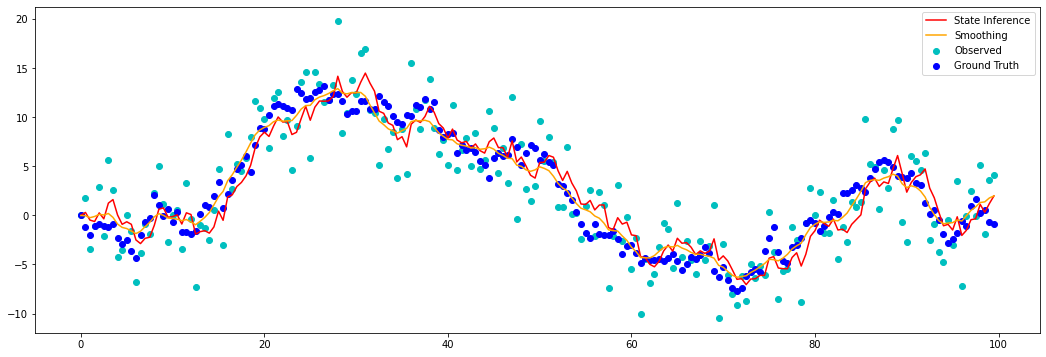

In [4]:
plt.rcParams["figure.figsize"] = (18, 6)

plt.scatter(time,y,label="Observed",color="c")
plt.scatter(time,z,label="Ground Truth",color="b")
plt.plot(time,xnn,color='r',label="State Inference")
plt.plot(time,sx, color='orange', label="Smoothing")
plt.legend()